In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import StandardScaler

### EDA

**Dataset overview** 

We build a monthly U.S. macro–financial panel to nowcast recession risk. The target is the NBER recession indicator (**USRECM**, binary), taken from FRED. 

Predictors include: 

- the **10Y–3M Treasury yield spread (T10Y3M)**—a well-known leading recession signal (source: FRED; cross-checked with the New York Fed),

- the unemployment rate (**UNRATE**), 

- consumer prices (**CPIAUCSL**, used in level and YoY change), 

- industrial production (**INDPRO**), 

- housing starts (**HOUST**), 

- and consumer sentiment (**UMCSENT**). 

All series are sourced from **FRED** (Federal Reserve Economic Data), aligned to a monthly calendar, and merged on the month start. We engineer standard transformations (lags, month-over-month and year-over-year changes). The classification label is shifted **h months ahead** to avoid look-ahead bias. This dataset balances macro breadth (real, prices, labor, housing, sentiment) with a parsimonious set of robust leading indicators for recession nowcasting.

In [10]:
files = {
    "recession": "data/us_recession.csv",
    "unrate": "data/unrate.csv",
    "sentiment": "data/umcsent.csv",
    "indpro": "data/indpro.csv",
    "housing": "data/houst.csv",
    "cpi": "data/cpi.csv",
    "treasury_spread": "data/1030treasury_spreads.csv",
}



def load_series(path, series_name):
    data = pd.read_csv(path, parse_dates=["observation_date"])
    value_cols = [c for c in data.columns if c != "observation_date"]
    if len(value_cols) != 1:
        raise ValueError(f"{path} devrait n’avoir qu’une colonne de données")
    series = data.rename(columns={value_cols[0]: series_name}).set_index("observation_date")
    if series_name == "treasury_spread":
        series = series.resample("MS").mean() # resemple to monthly data as it is in daily originally
    return series

series = [load_series(path, name) for name, path in files.items()] # concatenate all series to one df and aligning available dates
df = pd.concat(series, axis=1, join="inner").sort_index().reset_index()
df["sentiment"] = df["sentiment"].ffill().shift(1) # shift by 1 month to avoid look-ahead (use info available by month-end)
df["recession"] = df["recession"].astype(int)
df = df.dropna()
print(df.shape, df.dtypes)

(523, 8) observation_date    datetime64[ns]
recession                    int64
unrate                     float64
sentiment                  float64
indpro                     float64
housing                      int64
cpi                        float64
treasury_spread            float64
dtype: object


In [11]:
df.head()

,observation_date,recession,unrate,sentiment,indpro,housing,cpi,treasury_spread
1,1982-02-01,1,8.9,71.0,49.7839,866,94.7,0.146111
2,1982-03-01,1,9.0,66.5,49.4477,931,94.7,0.546522
3,1982-04-01,1,9.3,62.0,48.9913,917,95.0,0.527143
4,1982-05-01,1,9.4,65.5,48.6669,1025,95.9,0.908500
5,1982-06-01,1,9.6,67.5,48.5415,902,97.0,1.220909


In [12]:
df.describe()

,observation_date,recession,unrate,sentiment,indpro,housing,cpi,treasury_spread
count,523,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000
mean,2003-10-31 19:08:08.718929280,0.095602,5.965774,85.711855,84.036511,1372.040153,191.044226,1.557632
min,1982-02-01 00:00:00,0.000000,3.400000,50.000000,46.871300,478.000000,94.700000,-1.734545
25%,1992-12-16 12:00:00,0.000000,4.600000,76.000000,64.486700,1152.500000,142.550000,0.564795
50%,2003-11-01 00:00:00,0.000000,5.600000,89.500000,91.136900,1410.000000,185.100000,1.603000
75%,2014-09-16 00:00:00,0.000000,7.100000,94.950000,99.464400,1627.000000,236.693000,2.556750
max,2025-08-01 00:00:00,1.000000,14.800000,112.000000,104.211500,2273.000000,323.364000,4.146190
std,NaN,0.294327,1.824050,13.102428,18.048498,373.254292,60.082454,1.246901


In [13]:
df.isna().sum()

observation_date    0
recession           0
unrate              0
sentiment           0
indpro              0
housing             0
cpi                 0
treasury_spread     0
dtype: int64

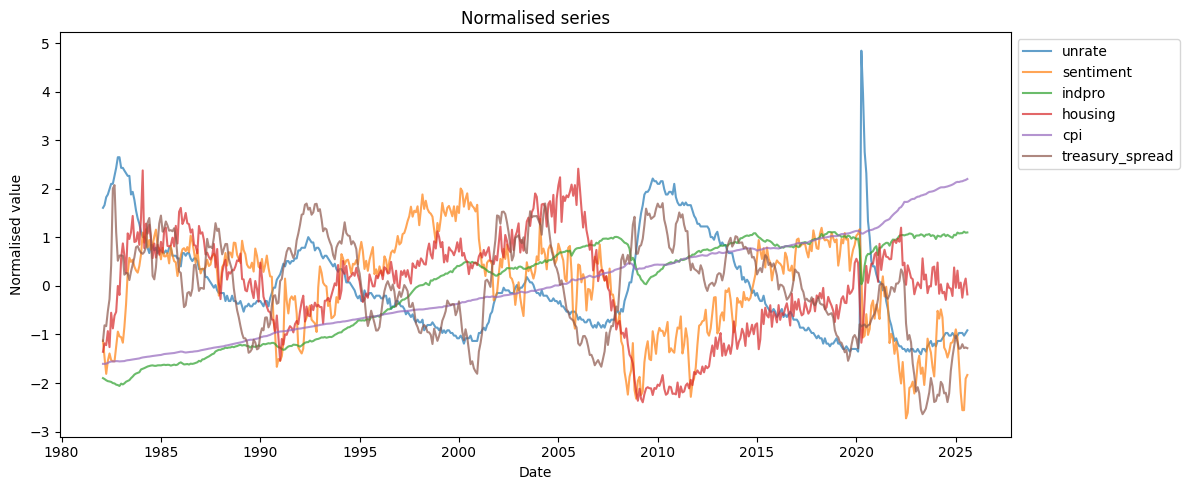

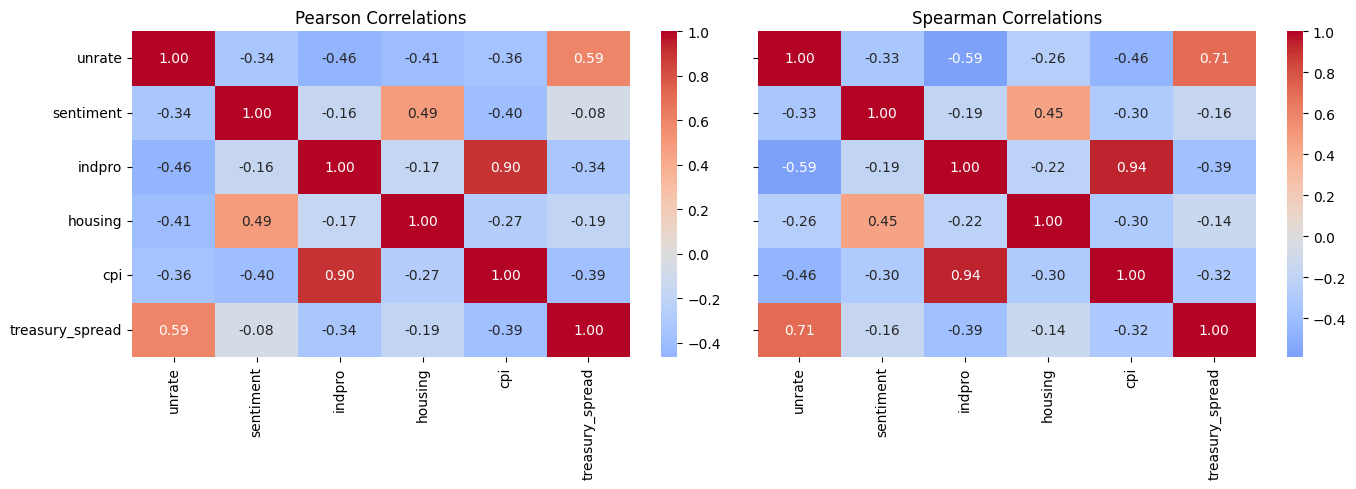

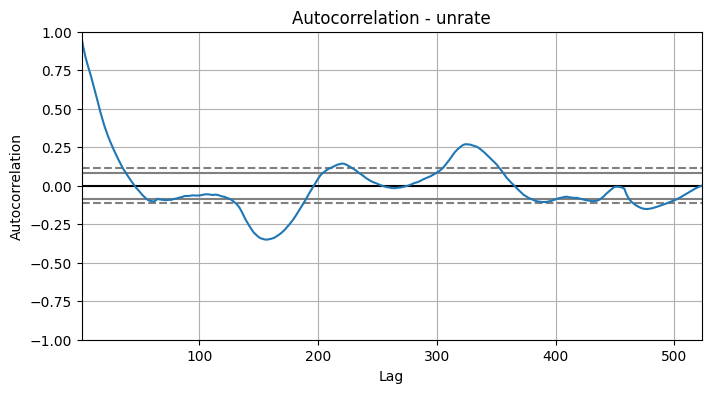

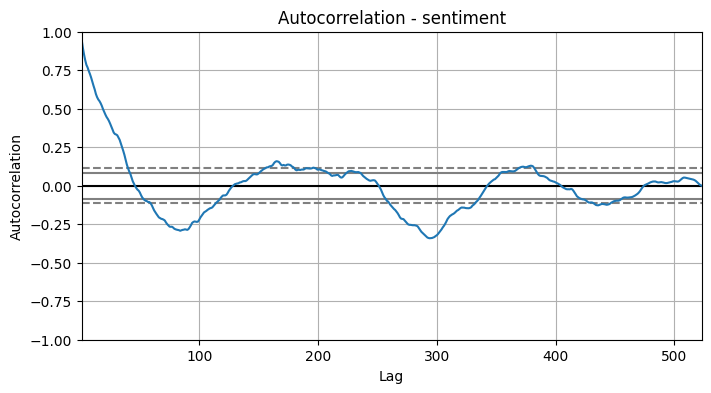

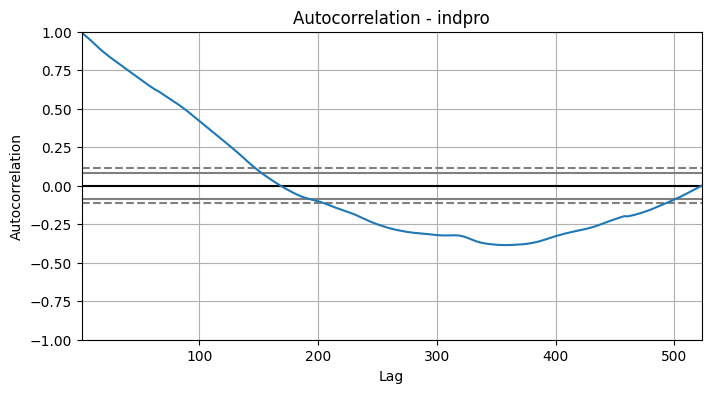

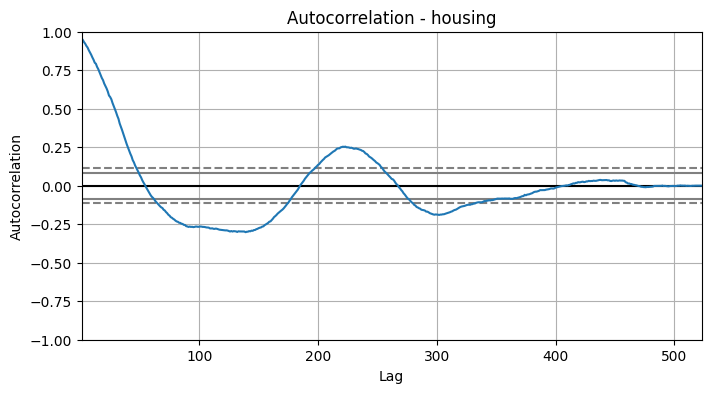

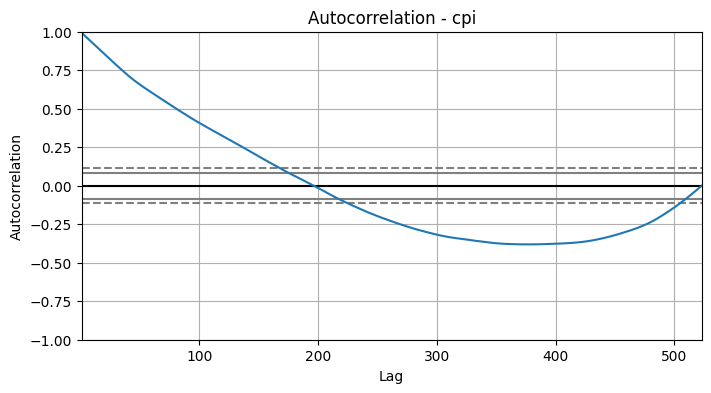

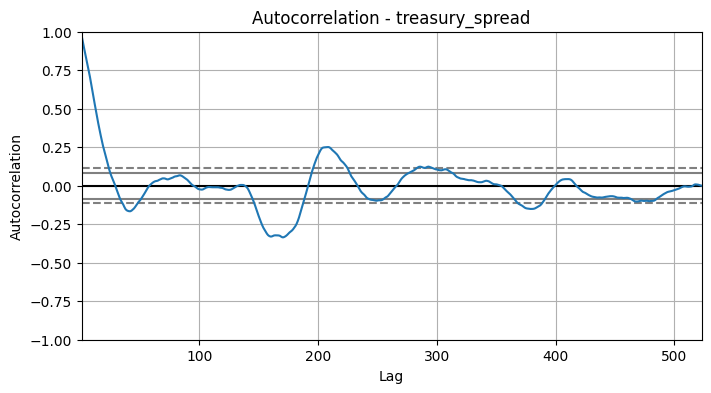

Label repartion: 
recession
0    473
1     50
Name: count, dtype: int64


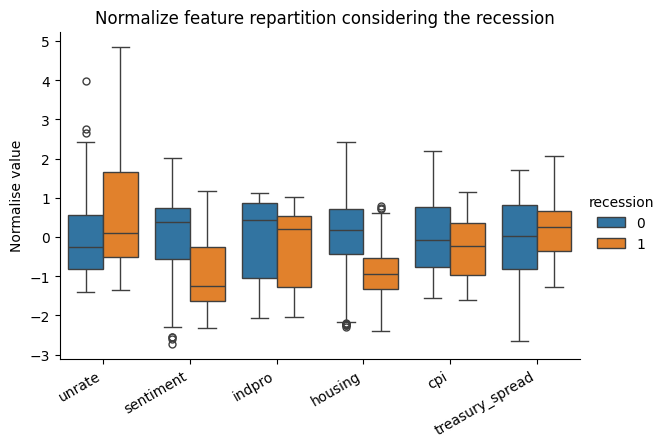

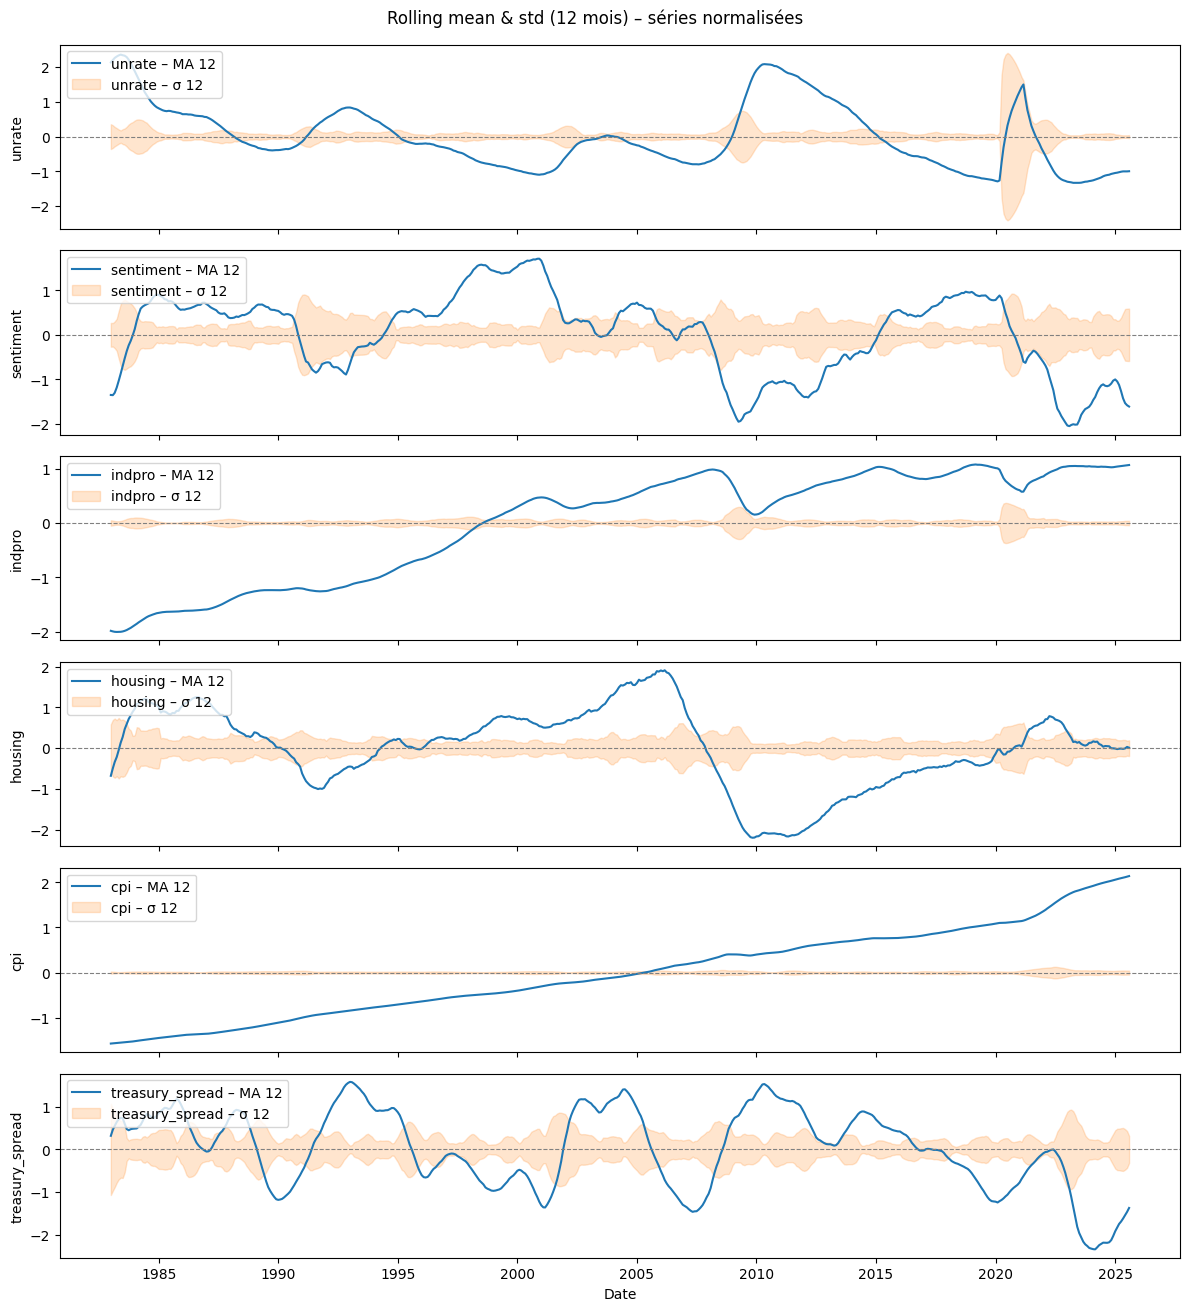

In [14]:
label_col = "recession"
date_col = "observation_date"
feature_cols = [c for c in df.columns if c not in {date_col, label_col}]
df_clean = df.copy()

# Normalised series
scaler = StandardScaler()
normalized = scaler.fit_transform(df_clean[feature_cols])
normalized_df = (pd.DataFrame(normalized, columns=feature_cols, index=df_clean[date_col]).sort_index())
plt.figure(figsize=(12, 5))
for col in normalized_df.columns:
    plt.plot(normalized_df.index, normalized_df[col], label=col, alpha=0.7)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("Normalised series")
plt.xlabel("Date")
plt.ylabel("Normalised value")
plt.tight_layout()
plt.show()

# Correlations
pearson_corr = df_clean[feature_cols].corr(method="pearson")
spearman_corr = df_clean[feature_cols].corr(method="spearman")

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)
sns.heatmap(pearson_corr, ax=axes[0], cmap="coolwarm", center=0, annot=True, fmt=".2f")
axes[0].set_title("Pearson Correlations")
sns.heatmap(spearman_corr, ax=axes[1], cmap="coolwarm", center=0, annot=True, fmt=".2f")
axes[1].set_title("Spearman Correlations")
plt.tight_layout()
plt.show()

# Autocorrelation
for col in feature_cols:
    plt.figure(figsize=(8, 4))
    autocorrelation_plot(df_clean.set_index(date_col)[col])
    plt.title(f"Autocorrelation - {col}")
    plt.show()

# Label balence
label_counts = df_clean[label_col].value_counts()
print("Label repartion: ")
print(label_counts)

# Label distribution
plot_data = (normalized_df[feature_cols].assign(recession=df_clean[label_col].values).reset_index().melt(id_vars=[date_col, label_col], var_name="feature", value_name="value"))
g = sns.catplot(data=plot_data,x="feature",y="value",hue="recession",kind="box",height=4,aspect=1.5)
g.set_xticklabels(rotation=30, ha="right")
g.fig.suptitle("Normalize feature repartition considering the recession", y=1.02)
plt.xlabel("")
plt.ylabel("Normalise value")
plt.show()

# Rolling mean/std
window = 12
rolling_mean = normalized_df[feature_cols].rolling(window).mean()
rolling_std = normalized_df[feature_cols].rolling(window).std()
fig, axes = plt.subplots(len(feature_cols), 1, sharex=True, figsize=(12, 2.2 * len(feature_cols)))
for ax, col in zip(axes, feature_cols):
    ax.plot(rolling_mean.index, rolling_mean[col], color="C0", label=f"{col} – MA {window}")
    ax.fill_between(
        rolling_std.index,
        -rolling_std[col],
        rolling_std[col],
        color="C1",
        alpha=0.2,
        label=f"{col} – σ {window}"
    )
    ax.axhline(0, color="gray", linewidth=0.8, linestyle="--")
    ax.set_ylabel(col)
    ax.legend(loc="upper left")
axes[-1].set_xlabel("Date")
fig.suptitle(f"Rolling mean & std ({window} mois) – séries normalisées", y=0.99)
plt.tight_layout()
plt.show()

Normalized series highlight consistent cyclical behavior: unemployment spikes and housing/sentiment contractions cluster around recession periods, whereas industrial production and CPI display longer-term drifts even after standardization.

Correlation matrices reveal a tight indpro–cpi block (0.90 Pearson / 0.94 Spearman) and strong inverse links with unemployment; the treasury spread mirrors unemployment (0.59 / 0.71), confirming its usefulness as an early-warning indicator.

Autocorrelation curves show substantial persistence in every series—slow decay for indpro and cpi, long oscillations for unrate, sentiment, and the spread—supporting the need for lagged and differenced features.

Boxplots on normalized values expose clear recession shifts: higher unrate and treasury_spread, lower sentiment, housing, and cpi; indpro compresses as well, albeit with weaker separation.

Rolling 12-month means/volatilities surface stress phases: volatility surges in unemployment and the spread around the 1990, 2008, and 2020 crises, while indpro/cpi evolve more gradually.

The label is moderatly imbalanced (1:10 ratio), so downstream modeling must address class imbalance through class weights.

### Feature Engineering

In [15]:
H = 6
def compute_features(files, horizon=H):
    series = [load_series(path, name) for name, path in files.items()]
    df = pd.concat(series, axis=1, join="inner").sort_index()
    # publication lags (safe practice): sentiment definitely 1M; others optional, but conservative to shift too
    df["sentiment"] = df["sentiment"].ffill().shift(1)
    # target: recession at t + H
    df["target"] = df["recession"].shift(-horizon).dropna().astype(int)
    df = df.dropna()
    
    # feature engineering on the info set at time t
    feature_cols = ["unrate","sentiment","indpro","housing","cpi","treasury_spread"]
    blocks = []
    for col in feature_cols:
        s = df[col]
        out = pd.DataFrame(index=df.index)
        out[f"{col}_lvl"] = s
        # use pct changes for real-activity/price series; diffs for rates/yields
        if col in ["indpro", "cpi", "housing", "sentiment"]:
            out[f"{col}_chg_1m"] = s.pct_change(1)
            out[f"{col}_chg_12m"] = s.pct_change(12)
        else:
            out[f"{col}_diff_1m"] = s.diff(1)
            out[f"{col}_diff_12m"] = s.diff(12)
        for L in [1, 3, 6, 12]:
            out[f"{col}_lag{L}"] = s.shift(L)
        blocks.append(out)

    X = pd.concat(blocks, axis=1)
    X = X.replace([np.inf, -np.inf], np.nan)
    data = pd.concat([X, df["target"]], axis=1).dropna()
    return data.drop(columns=["target"]), data["target"].astype(int)

X, y = compute_features(files)
X.head()


,unrate_lvl,unrate_diff_1m,unrate_diff_12m,unrate_lag1,unrate_lag3,unrate_lag6,unrate_lag12,sentiment_lvl,sentiment_chg_1m,sentiment_chg_12m,...,cpi_lag3,cpi_lag6,cpi_lag12,treasury_spread_lvl,treasury_spread_diff_1m,treasury_spread_diff_12m,treasury_spread_lag1,treasury_spread_lag3,treasury_spread_lag6,treasury_spread_lag12
observation_date,,,,,,,,,,,,,,,,,,,,,
1983-02-01,10.4,0.0,1.5,10.4,10.8,9.8,8.9,70.4,-0.020862,-0.008451,...,98.0,97.7,94.7,2.330526,-0.009474,2.184415,2.340000,2.204211,4.057727,0.146111
1983-03-01,10.3,-0.1,1.3,10.4,10.8,10.1,9.0,74.6,0.059659,0.121805,...,97.7,97.7,94.7,1.846957,-0.483570,1.300435,2.330526,2.337273,4.146190,0.546522
1983-04-01,10.2,-0.1,0.9,10.3,10.4,10.4,9.3,80.8,0.083110,0.303226,...,97.9,98.1,95.0,1.886500,0.039543,1.359357,1.846957,2.340000,2.939000,0.527143
1983-05-01,10.1,-0.1,0.7,10.2,10.4,10.8,9.4,89.1,0.102723,0.360305,...,98.0,98.0,95.9,1.884286,-0.002214,0.975786,1.886500,2.330526,2.204211,0.908500
1983-06-01,10.1,0.0,0.5,10.1,10.3,10.8,9.6,93.3,0.047138,0.382222,...,98.1,97.7,97.0,1.709091,-0.175195,0.488182,1.884286,1.846957,2.337273,1.220909


Classification report :
              precision    recall  f1-score   support

           0      1.000     0.388     0.559        98
           1      0.048     1.000     0.091         3

    accuracy                          0.406       101
   macro avg      0.524     0.694     0.325       101
weighted avg      0.972     0.406     0.545       101


Matrice de confusion :
[[38 60]
 [ 0  3]]

ROC AUC : 0.721


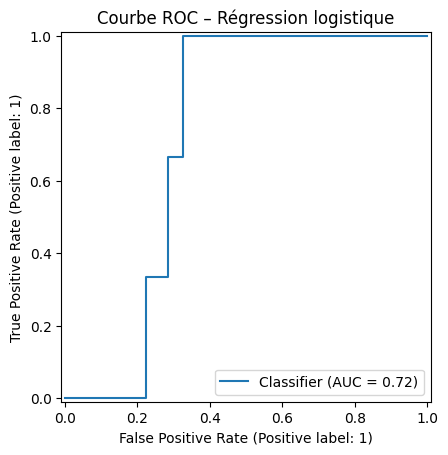

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay


split_idx = int(len(X) * 0.8)
X_train, y_train = X.iloc[:split_idx], y.iloc[:split_idx]
X_test, y_test = X.iloc[split_idx:], y.iloc[split_idx:]
log_reg_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(class_weight="balanced", max_iter=1000, solver="lbfgs")),
    ]
)
log_reg_pipeline.fit(X_train, y_train)
y_pred = log_reg_pipeline.predict(X_test)
y_prob = log_reg_pipeline.predict_proba(X_test)[:, 1]

print("Classification report :")
print(classification_report(y_test, y_pred, digits=3))
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred))
auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC : {auc:.3f}")
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("Courbe ROC – Régression logistique")
plt.show()